## <span style='color:#ff5f27'> 📝 Imports</span>

In [1]:
!pip install -r requirements.txt -q

In [2]:
import argparse  # For parsing command-line arguments
import math  # For mathematical functions
from pathlib import Path  # For filesystem path operations
import sys  # For system-specific parameters and functions

# Append './taming-transformers' to system path for module imports
sys.path.append('./taming-transformers')

# IPython display for rich outputs in Jupyter notebooks
from IPython import display

# Base64 encoding for binary data
from base64 import b64encode

# Configuration management
from omegaconf import OmegaConf

# Image handling from Python Imaging Library
from PIL import Image

# Import specific models from taming-transformers
from taming.models import cond_transformer, vqgan

# PyTorch for building and training neural networks
import torch
from torch import nn, optim
from torch.nn import functional as F

# Transformations for image preprocessing
from torchvision import transforms
from torchvision.transforms import functional as TF

# Progress bars for Jupyter notebooks
from tqdm.notebook import tqdm

# Import CLIP model from local module
from CLIP import clip

# Kornia for image augmentations
import kornia.augmentation as K

# Numerical operations
import numpy as np
# Image IO for reading and writing images
import imageio

# Ensure PIL can handle truncated images
from PIL import ImageFile, Image
ImageFile.LOAD_TRUNCATED_IMAGES = True

# JSON handling and OS operations
import json
import os

from functions.model import (
    load_vqgan_model,
    vector_quantize,
    REPLACE_GRAD,
    CLAMP_WITH_GRAD,
)
from functions.utils import(
    clear_folder,
    create_gif,
)
import config

## <span style='color:#ff5f27'> 🤖 Model Loading</span>

## <span style='color:#ff5f27'> ⚙️ Setup</span>

In [3]:
def sinc(x):
    """
    Calculate the sinc function for the given input tensor x.
    The sinc function is defined as sin(pi * x) / (pi * x), with sinc(0) = 1.

    This function is used in the Lanczos filter for image resampling,
    which helps in high-quality resizing of images.

    Parameters:
    x (torch.Tensor): Input tensor.

    Returns:
    torch.Tensor: Output tensor after applying the sinc function.
    """
    return torch.where(x != 0, torch.sin(math.pi * x) / (math.pi * x), x.new_ones([]))


def lanczos(x, a):
    """
    Apply the Lanczos resampling filter to the input tensor x.

    The Lanczos filter is used for high-quality image resampling.
    It is particularly effective in reducing aliasing artifacts during resizing.

    Parameters:
    x (torch.Tensor): Input tensor.
    a (int): Lanczos filter parameter.

    Returns:
    torch.Tensor: Filtered tensor.
    """
    # Condition to check the range of the Lanczos filter
    cond = torch.logical_and(-a < x, x < a)
    # Apply the sinc function and set values outside the range to zero
    out = torch.where(cond, sinc(x) * sinc(x / a), x.new_zeros([]))
    # Normalize the filter to ensure the sum of its values is 1
    return out / out.sum()



def ramp(ratio, width):
    """
    Create a ramp tensor based on the given ratio and width.

    The ramp function generates a linear ramp, which is useful for creating filters
    or for use in image transformations that require gradual changes.

    Parameters:
    ratio (float): Ratio for the ramp.
    width (int): Width of the ramp.

    Returns:
    torch.Tensor: Ramp tensor.
    """
    # Calculate the number of points in the ramp
    n = math.ceil(width / ratio + 1)
    # Create an empty tensor to hold the ramp values
    out = torch.empty([n])
    cur = 0
    # Fill the tensor with values incremented by the ratio
    for i in range(out.shape[0]):
        out[i] = cur
        cur += ratio
    # Create a symmetrical ramp by concatenating the flipped version of the ramp
    return torch.cat([-out[1:].flip([0]), out])[1:-1]



def resample(input, size, align_corners=True):
    """
    Resample the input tensor to the given size using bicubic interpolation.

    This function is crucial for resizing images while maintaining high quality.
    It applies the Lanczos filter before resizing to prevent aliasing artifacts.

    Parameters:
    input (torch.Tensor): Input tensor of shape (n, c, h, w).
    size (tuple): Desired output size (height, width).
    align_corners (bool): Whether to align corners when resizing.

    Returns:
    torch.Tensor: Resampled tensor.
    """
    n, c, h, w = input.shape  # Get the shape of the input tensor
    dh, dw = size  # Desired height and width

    # Reshape the input tensor for convolution operations
    input = input.view([n * c, 1, h, w])

    # Apply the Lanczos filter for downscaling if the desired height is less than the current height
    if dh < h:
        # Generate the Lanczos kernel for the height dimension
        kernel_h = lanczos(ramp(dh / h, 2), 2).to(input.device, input.dtype)
        # Calculate the padding needed for the convolution
        pad_h = (kernel_h.shape[0] - 1) // 2
        # Apply reflection padding to the input tensor
        input = F.pad(input, (0, 0, pad_h, pad_h), 'reflect')
        # Perform the convolution with the Lanczos kernel
        input = F.conv2d(input, kernel_h[None, None, :, None])
        
    # Apply the Lanczos filter for downscaling if the desired width is less than the current width
    if dw < w:
        # Generate the Lanczos kernel for the width dimension
        kernel_w = lanczos(ramp(dw / w, 2), 2).to(input.device, input.dtype)
        # Calculate the padding needed for the convolution
        pad_w = (kernel_w.shape[0] - 1) // 2
        # Apply reflection padding to the input tensor
        input = F.pad(input, (pad_w, pad_w, 0, 0), 'reflect')
        # Perform the convolution with the Lanczos kernel
        input = F.conv2d(input, kernel_w[None, None, None, :])

    # Reshape the input tensor back to its original shape
    input = input.view([n, c, h, w])
    # Resize the input tensor to the desired size using bicubic interpolation
    return F.interpolate(input, size, mode='bicubic', align_corners=align_corners)


class Prompt(nn.Module):
    """
    Prompt class for embedding and managing prompts in the model.

    This class is used to embed and manage text prompts for guiding the
    image generation process.
    """
    def __init__(self, embed, weight=1., stop=float('-inf')):
        """
        Initialize the Prompt class.

        Parameters:
        embed (torch.Tensor): Embedding tensor.
        weight (float): Weight for the prompt.
        stop (float): Stop threshold.
        """
        super().__init__()
        # Register buffers for embedding, weight, and stop threshold
        self.register_buffer('embed', embed)
        self.register_buffer('weight', torch.as_tensor(weight))
        self.register_buffer('stop', torch.as_tensor(stop))

    def forward(self, input):
        """
        Forward pass for the prompt.

        Parameters:
        input (torch.Tensor): Input tensor.

        Returns:
        torch.Tensor: Output tensor after applying the prompt.
        """
        # Normalize the input and embedding tensors
        input_normed = F.normalize(input.unsqueeze(1), dim=2)
        embed_normed = F.normalize(self.embed.unsqueeze(0), dim=2)
        # Calculate the distance between input and embedding
        dists = input_normed.sub(embed_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2)
        # Apply the weight and stop threshold
        dists = dists * self.weight.sign()
        return self.weight.abs() * REPLACE_GRAD(dists, torch.maximum(dists, self.stop)).mean()

    
def parse_prompt(prompt):
    """
    Parse the prompt string into its components: text, weight, and stop.

    This function is used to interpret the text prompt and its associated
    parameters for guiding the image generation process.

    Parameters:
    prompt (str): Prompt string in the format "text:weight:stop".

    Returns:
    tuple: Parsed components (text, weight, stop).
    """
    # Split the prompt string into components
    vals = prompt.rsplit(':', 2)
    # Ensure the components list has three elements
    vals = vals + ['', '1', '-inf'][len(vals):]
    return vals[0], float(vals[1]), float(vals[2])

 

class MakeCutouts(nn.Module):
    """
    Class for making random cutouts of input images with optional augmentations.

    This class is used to create multiple random cutouts from input images,
    which helps in augmenting the dataset and improving the robustness
    of the model.
    """
    def __init__(self, cut_size, cutn, cut_pow=1.):
        """
        Initialize the MakeCutouts class.

        Parameters:
        cut_size (int): Size of the cutouts.
        cutn (int): Number of cutouts.
        cut_pow (float): Power for random size scaling.
        """
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.cut_pow = cut_pow
        # Define the augmentation pipeline
        self.augs = nn.Sequential(
            K.RandomHorizontalFlip(p=0.5),
            # K.RandomSolarize(0.01, 0.01, p=0.7),
            K.RandomSharpness(0.3, p=0.4),
            K.RandomAffine(degrees=30, translate=0.1, p=0.8, padding_mode='border'),
            K.RandomPerspective(0.2, p=0.4),
            K.ColorJitter(hue=0.01, saturation=0.01, p=0.7)
        )
        self.noise_fac = 0.1

    def forward(self, input):
        """
        Forward pass to create cutouts with augmentations.

        Parameters:
        input (torch.Tensor): Input image tensor.

        Returns:
        torch.Tensor: Tensor of augmented cutouts.
        """
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.cut_size)
        cutouts = []
        # Create multiple random cutouts
        for _ in range(self.cutn):
            size = int(torch.rand([]) ** self.cut_pow * (max_size - min_size) + min_size)
            offsetx = torch.randint(0, sideX - size + 1, ())
            offsety = torch.randint(0, sideY - size + 1, ())
            cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]
            cutouts.append(resample(cutout, (self.cut_size, self.cut_size)))
        # Apply augmentations to the cutouts
        batch = self.augs(torch.cat(cutouts, dim=0))
        if self.noise_fac:
            facs = batch.new_empty([self.cutn, 1, 1, 1]).uniform_(0, self.noise_fac)
            batch = batch + facs * torch.randn_like(batch)
        return batch


def resize_image(image, out_size):
    """
    Resize an image while maintaining the aspect ratio using the LANCZOS filter.

    This function resizes an image to the specified output size while preserving
    the original aspect ratio, using the high-quality LANCZOS filter.

    Parameters:
    image (PIL.Image): Input image.
    out_size (tuple): Desired output size (width, height).

    Returns:
    PIL.Image: Resized image.
    """
    # Calculate the aspect ratio of the input image
    ratio = image.size[0] / image.size[1]
    # Calculate the area of the output size
    area = min(image.size[0] * image.size[1], out_size[0] * out_size[1])
    # Calculate the new size while maintaining the aspect ratio
    size = round((area * ratio) ** 0.5), round((area / ratio) ** 0.5)
    # Resize the image using the LANCZOS filter
    return image.resize(size, Image.LANCZOS)


In [4]:
# Usage example
clear_folder('CLIP_sampling')

In [5]:
# Define the main prompt for the image generation
prompts = "A beautiful morning city with many trees, lush green parks, and vibrant flowers, creating a picturesque and serene environment."
# Set the dimensions for the generated images
width = 512
height = 512

# Define the frequency for displaying intermediate results during training
display_frequency = 50
# Specify the initial image to start the generation process
initial_image = "data/coco_segmentations/000000237928.png" #"data/coco_segmentations/000000335529.png"  
# Define target images (if any) for guiding the generation
target_images = "" #@param {type:"string"}
# Set the random seed for reproducibility (-1 means no specific seed)
seed = -1 #@param {type:"number"}
# Set the maximum number of iterations for the generation process
max_iterations = 500 #@param {type:"number"}
# Variable to hold input images (initial or target images)
input_images = ""


In [6]:
# If no seed is specified, set seed to None for random behavior
if seed == -1:
    seed = None
# If no initial image is specified, set initial_image to None
if initial_image == "None":
    initial_image = None
# If no target images are specified, set target_images to an empty list
if target_images == "None" or not target_images:
    target_images = []
else:
    # Split the target images by "|" and strip any extra whitespace
    target_images = target_images.split("|")
    target_images = [image.strip() for image in target_images]

# If an initial image or target images are provided, set input_images to True
if initial_image or target_images != []:
    input_images = True

# Split the prompt string by "|" and strip any extra whitespace
prompts = [frase.strip() for frase in prompts.split("|")]
# If the prompt list contains an empty string, set prompts to an empty list
if prompts == ['']:
    prompts = []


In [7]:
# Create an argparse.Namespace object to hold all the parameters
args = argparse.Namespace(
    prompts=prompts,                                                                                    # List of text prompts
    image_prompts=target_images,                                                                        # List of target images
    noise_prompt_seeds=[],                                                                              # List of seeds for noise prompts (empty in this case)
    noise_prompt_weights=[],                                                                            # List of weights for noise prompts (empty in this case)
    size=[width, height],  # Size of the generated images
    init_image=initial_image,  # Initial image for starting the generation process
    init_weight=0.,  # Initial weight for the initial image influence
    clip_model='ViT-B/32',  # CLIP model type to be used
    vqgan_config='logs/2021-01-20T16-04-20_coco_transformer/configs/2021-02-08T17-18-53-project.yaml',  # VQGAN config file path
    vqgan_checkpoint='logs/2021-01-20T16-04-20_coco_transformer/model_ckpt/last.ckpt',  # VQGAN checkpoint file path
    step_size=0.1,  # Step size for optimization
    cutn=64,  # Number of cutouts for augmentations
    cut_pow=1.,  # Power for random size scaling of cutouts
    display_freq=display_frequency,  # Frequency for displaying intermediate results
    seed=seed,  # Random seed for reproducibility
)


🚀 Using device: cuda:0
📝 Using text prompt: ['A beautiful morning city with many trees, lush green parks, and vibrant flowers, creating a picturesque and serene environment.']
Using seed: 16401118397210488824
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Restored from logs/2021-01-20T16-04-20_coco_transformer/coco_cond_stage.ckpt
2024-07-17 19:38:52,643 INFO: number of parameters: 6.513075e+08
Restored from logs/2021-01-20T16-04-20_coco_transformer/model_ckpt/last.ckpt


100%|███████████████████████████████████████| 338M/338M [00:05<00:00, 68.0MiB/s]


0it [00:00, ?it/s]

i: 0, loss: 0.998332, losses: 0.998332


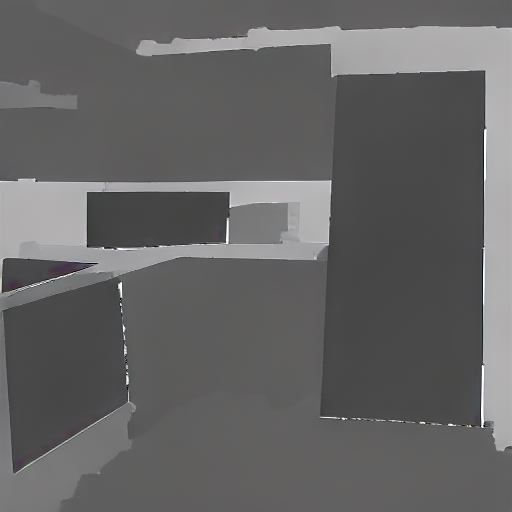

i: 50, loss: 0.836628, losses: 0.836628


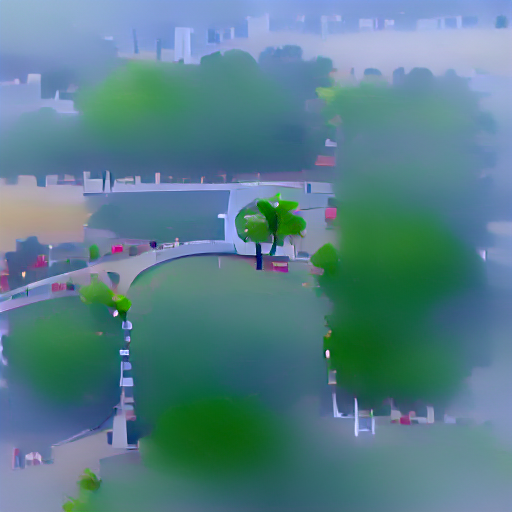

i: 100, loss: 0.766682, losses: 0.766682


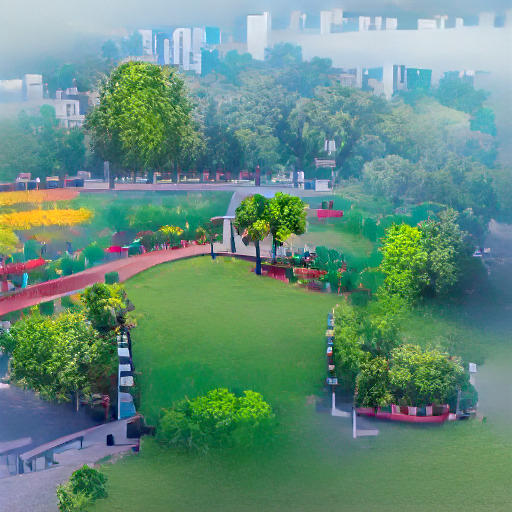

i: 150, loss: 0.750771, losses: 0.750771


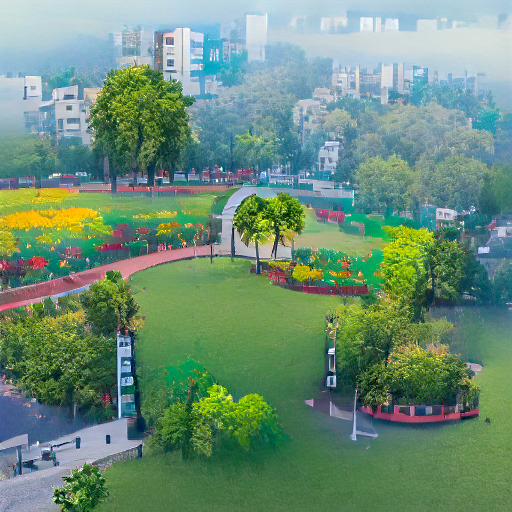

i: 200, loss: 0.746589, losses: 0.746589


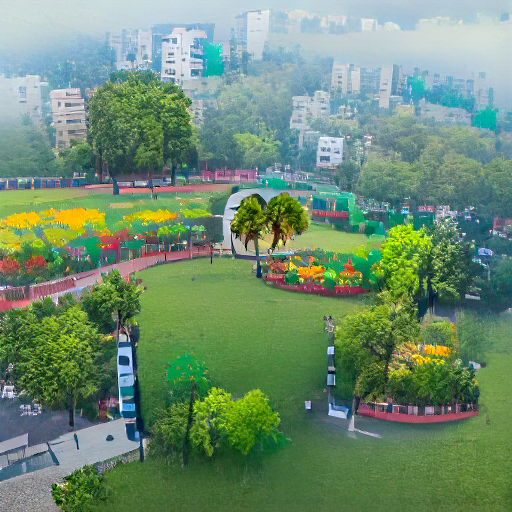

i: 250, loss: 0.742671, losses: 0.742671


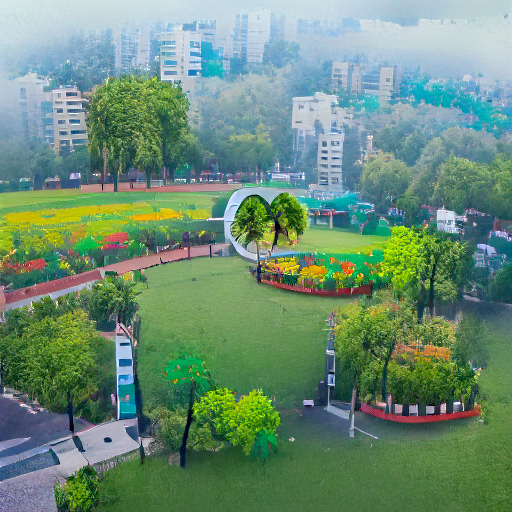

i: 300, loss: 0.73583, losses: 0.73583


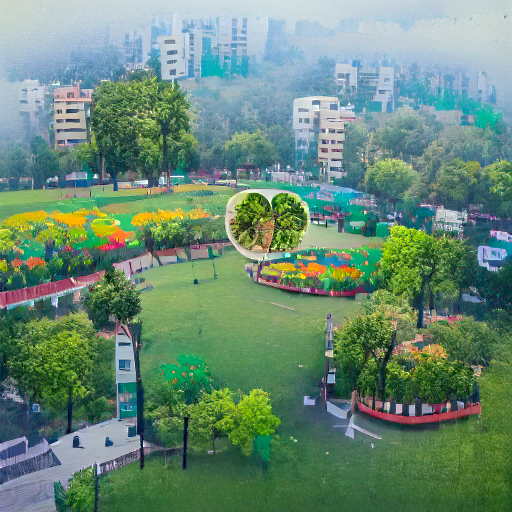

i: 350, loss: 0.732912, losses: 0.732912


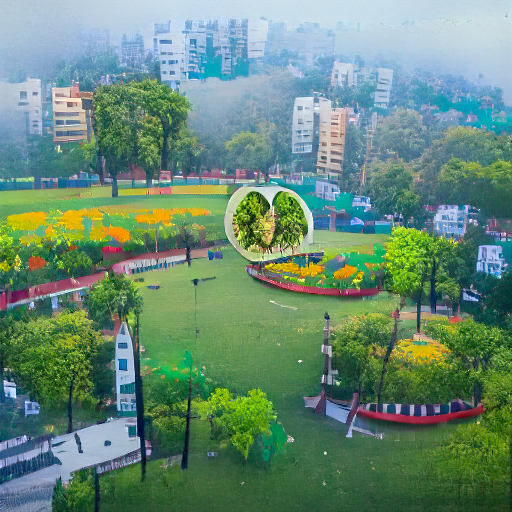

i: 400, loss: 0.733501, losses: 0.733501


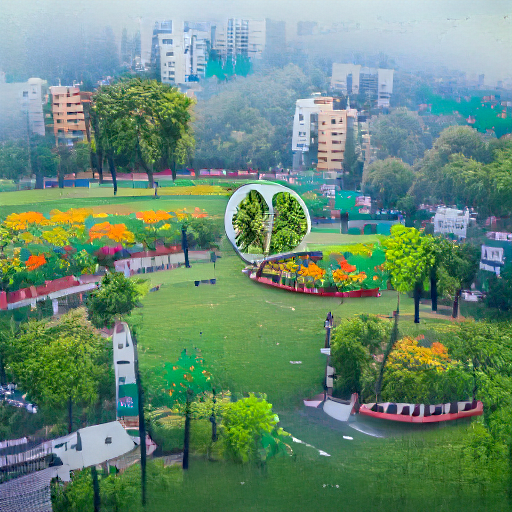

i: 450, loss: 0.725698, losses: 0.725698


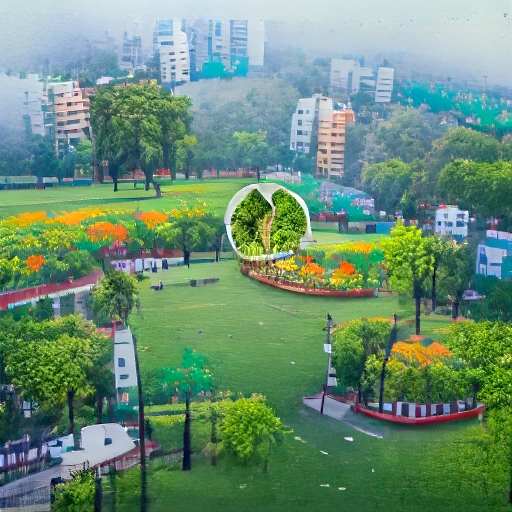

i: 500, loss: 0.721988, losses: 0.721988


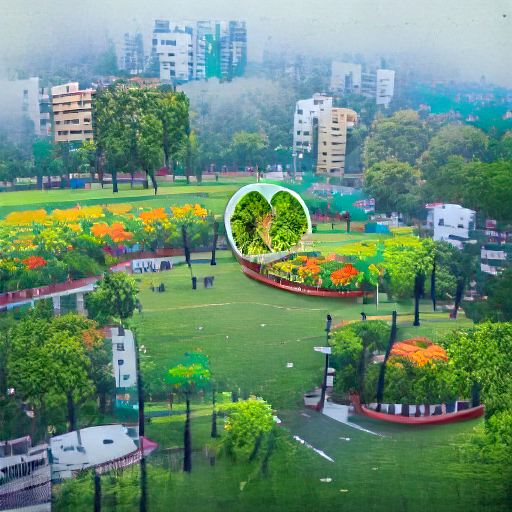

In [8]:
# Print the device being used (CPU or GPU)
print('🚀 Using device:', config.DEVICE)

# Print the text and image prompts if provided
if prompts:
    print('📝 Using text prompt:', prompts)
if target_images:
    print('Using image prompts:', target_images)

# Set the random seed for reproducibility
if args.seed is None:
    seed = torch.seed()
else:
    seed = args.seed
torch.manual_seed(seed)
print('Using seed:', seed)

# Load the VQGAN model and the CLIP model
model = load_vqgan_model(args.vqgan_config, args.vqgan_checkpoint).to(config.DEVICE)
perceptor = clip.load(args.clip_model, jit=False)[0].eval().requires_grad_(False).to(config.DEVICE)

# Determine the input resolution for CLIP and the dimensions of the quantized embeddings in VQGAN
cut_size = perceptor.visual.input_resolution  # Input resolution for CLIP model
e_dim = model.quantize.e_dim  # Dimension of the quantized embeddings in VQGAN
# Compute the downscaling factor based on the number of resolutions in the VQGAN decoder
f = 2**(model.decoder.num_resolutions - 1)

# Create an instance of MakeCutouts to generate cutouts of the input image
make_cutouts = MakeCutouts(cut_size, args.cutn, cut_pow=args.cut_pow)

# Get the number of tokens and token dimensions in the VQGAN model
n_toks = model.quantize.n_e  # Number of tokens in the VQGAN quantizer
toksX, toksY = args.size[0] // f, args.size[1] // f  # Token dimensions of the image
sideX, sideY = toksX * f, toksY * f  # Image dimensions

# Determine the min and max values for the quantized embeddings
z_min = model.quantize.embedding.weight.min(dim=0).values[None, :, None, None]  # Minimum values for quantized embeddings
z_max = model.quantize.embedding.weight.max(dim=0).values[None, :, None, None]  # Maximum values for quantized embeddings

# Create directory to save progress images if it doesn't exist
if not os.path.exists('CLIP_sampling'):
    os.makedirs('CLIP_sampling')

# Initialize the latent vector z
if args.init_image:
    # Load and preprocess the initial image
    pil_image = Image.open(args.init_image).convert('RGB')
    # Resize the image to match the expected input size for VQGAN
    pil_image = pil_image.resize((sideX, sideY), Image.LANCZOS)
    # Encode the image using the VQGAN model
    z, *_ = model.encode(TF.to_tensor(pil_image).to(config.DEVICE).unsqueeze(0) * 2 - 1)
else:
    # Initialize z with random noise if no initial image is provided
    one_hot = F.one_hot(torch.randint(n_toks, [toksY * toksX], device=config.DEVICE), n_toks).float()
    z = one_hot @ model.quantize.embedding.weight
    z = z.view([-1, toksY, toksX, e_dim]).permute(0, 3, 1, 2)

# Create a clone of the initial latent vector z for comparison during optimization
z_orig = z.clone()
z.requires_grad_(True)  # Enable gradient computation for z

# Initialize the optimizer for updating z
opt = optim.Adam([z], lr=args.step_size)

# Define normalization parameters for the CLIP model
normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                 std=[0.26862954, 0.26130258, 0.27577711])

# Initialize a list to store the processed prompts
pMs = []

# Process text prompts
for prompt in args.prompts:
    # Parse the prompt to extract the text, weight, and stopping criterion
    txt, weight, stop = parse_prompt(prompt)
    # Encode the text using the CLIP model
    embed = perceptor.encode_text(clip.tokenize(txt).to(config.DEVICE)).float()
    # Create a Prompt object and add it to the list
    pMs.append(Prompt(embed, weight, stop).to(config.DEVICE))

# Process image prompts
for prompt in args.image_prompts:
    # Parse the prompt to extract the image path, weight, and stopping criterion
    path, weight, stop = parse_prompt(prompt)
    # Load and resize the image
    img = resize_image(Image.open(path).convert('RGB'), (sideX, sideY))
    # Create cutouts of the image
    batch = make_cutouts(TF.to_tensor(img).unsqueeze(0).to(config.DEVICE))
    # Encode the image using the CLIP model
    embed = perceptor.encode_image(normalize(batch)).float()
    # Create a Prompt object and add it to the list
    pMs.append(Prompt(embed, weight, stop).to(config.DEVICE))

# Process noise prompts
for seed, weight in zip(args.noise_prompt_seeds, args.noise_prompt_weights):
    # Set the random seed for generating noise
    gen = torch.Generator().manual_seed(seed)
    # Generate a random noise vector
    embed = torch.empty([1, perceptor.visual.output_dim]).normal_(generator=gen)
    # Create a Prompt object and add it to the list
    pMs.append(Prompt(embed, weight).to(config.DEVICE))

# Function to synthesize an image from the latent vector z
def synth(z):
    # Quantize the latent vector z using the VQGAN codebook
    z_q = vector_quantize(z.movedim(1, 3), model.quantize.embedding.weight).movedim(3, 1)
    # Decode the quantized vector to generate an image
    return CLAMP_WITH_GRAD(model.decode(z_q).add(1).div(2), 0, 1)

# Function to log progress and save images
@torch.no_grad()
def checkin(i, losses):
    # Convert losses to a string for logging
    losses_str = ', '.join(f'{loss.item():g}' for loss in losses)
    # Log the iteration number and total loss
    tqdm.write(f'i: {i}, loss: {sum(losses).item():g}, losses: {losses_str}')
    # Synthesize an image from the latent vector z
    out = synth(z)
    # Save the synthesized image
    TF.to_pil_image(out[0].cpu()).save('progress.png')
    # Display the saved image
    display.display(display.Image('progress.png'))

# Function to calculate losses for text prompts
def ascend_txt():
    global i
    # Synthesize an image from the latent vector z
    out = synth(z)
    # Encode the synthesized image using the CLIP model
    iii = perceptor.encode_image(normalize(make_cutouts(out))).float()

    # Initialize a list to store the losses
    result = []

    # Add the initialization weight loss if applicable
    if args.init_weight:
        result.append(F.mse_loss(z, z_orig) * args.init_weight / 2)

    # Add losses for each prompt
    for prompt in pMs:
        result.append(prompt(iii))

    # Convert the synthesized image to a NumPy array
    img = np.array(out.mul(255).clamp(0, 255)[0].cpu().detach().numpy().astype(np.uint8))[:,:,:]
    # Transpose the image dimensions
    img = np.transpose(img, (1, 2, 0))
    # Save the image with the current iteration number in the filename
    filename = f"CLIP_sampling/{i:04}.png"
    imageio.imwrite(filename, np.array(img))
    return result

# Function to train the model
def train(i):
    # Zero the gradients for the optimizer
    opt.zero_grad()
    # Calculate the losses for the current iteration
    lossAll = ascend_txt()
    # Log progress and save images at specified intervals
    if i % args.display_freq == 0:
        checkin(i, lossAll)
    # Sum the losses
    loss = sum(lossAll)
    # Perform backpropagation to calculate gradients
    loss.backward()
    # Update the latent vector z using the optimizer
    opt.step()
    # Clamp the values of z to be within the specified range
    with torch.no_grad():
        z.copy_(z.maximum(z_min).minimum(z_max))

# Initialize the iteration counter
i = 0
try:
    # Create a progress bar using tqdm
    with tqdm() as pbar:
        # Run the training loop until the maximum number of iterations is reached
        while True:
            train(i)
            if i == max_iterations:
                break
            i += 1
            pbar.update()
except KeyboardInterrupt:
    pass

In [9]:
# Create GIF
create_gif('gifs/CLIP/CLIP_night_city.gif', folder_path='CLIP_sampling', duration=100)

GIF saved to gifs/CLIP/CLIP_night_city.gif


---